# Práctica básica de filtro adaptado

En esta práctica usaremos:

In [1]:
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt

## Generación de la señal de prueba
La idea es comparar la performance de un filtro cualquiera (LP, BP, o HP) contra el filtro adaptado. Para ello generaremos una señal que podamos procesar con ambos.

Conformaremos la señal con una parte conocida (_header_) y otra parte totalmente aleatoria que hace las veces de información útil (_payload_).

El header serán 16 bytes `0xAC` (10101100):

In [2]:
header = [1, 0, 1, 0, 1, 1, 0, 0] * 16

Los bits de información los generaremos aleatoriamente para simular información útil, aunque utilizaremos una semilla determinada para poder repetir los experimentos.

In [3]:
np.random.seed(42)
info = np.random.randint(0, 2, 1500)

Finalmente, los bits de la señal completa son:

In [4]:
bits = np.concatenate((header, info))

### Modulación y efecto del canal

La modulación constará simplemente en envíar un pulso positivo (1) o negativo (-1) según los bis sean `0` ó `1` respectivamente. 

In [5]:
data = np.where(bits != 0, 1, -1)

Ahora consideremos los efectos del canal...

Lo primero es considerar que el canal posee mútilpes trayectorias por lo que a nuestro "receptor" llegarían N copias de la señal retardadas, por ejemplo podría ser el siguiente caso:
![multipath](img/Multipath.png "Un escenario de ejemplo de multipath")


Para ello, en este caso sencillo modelaremos al canal como una suma de 20 copias de cada símbolo retrasadas en una muestra, con una amplitud decreciente exponencial. Es decir entre símbolo y símbolo tendremos 20 ecos (conocidos como _TAPs_ del canal). 

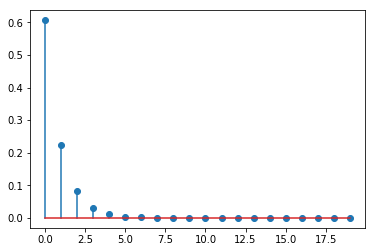

In [6]:
tpulse = np.linspace(-1, 1, 2*10, endpoint=False)
pulse = sp.exponential(40)[20::]
plt.figure('Pulso (respuesta del canal)')
_ = plt.stem(pulse)

Ahora armaremos la señal con el efecto del _multipath_:

In [7]:
signal = np.zeros(len(data)*len(pulse))
signal[10::20] = data[:]  # Se agrega un offset para que luego de la convolución, el primer pulso comience en 0
signal = np.convolve(signal, pulse, mode='same')

Lo que, por ejemplo, para el primer byte da:

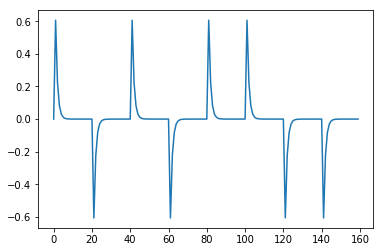

In [8]:
_ = plt.plot(signal[:160])

Ahra bien, para terminar de simular los efectos de un canal real y el hardware de un receptor se agrega ruido AWG y un offset de continua:

In [9]:
DC_offset = 1.5
Noise_PW = 0.5
noise = np.random.randn(len(signal))*Noise_PW
signal = signal + noise + DC_offset

Lo que resulta para el primer byte:

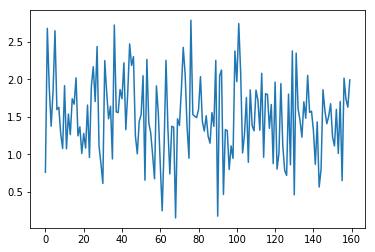

In [10]:
_ = plt.plot(signal[:20*8])

## Filtrado de la señal

### Filtro LP:

Definimos un filtro LP genérico en función del espectro del pulso envíado:

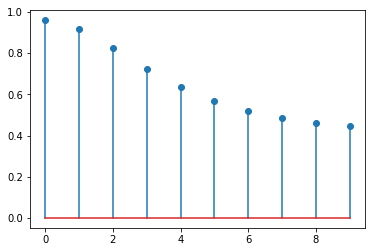

In [11]:
_ = plt.stem(abs(np.fft.fft(pulse))[0:len(pulse)//2])

Del espectro de la figura anterior, un posible criterio sería filtrar a partir de la frecuencia en que los coeficientes caen por debajo del valor medio entre el máximo y el mínimo ($\sim 0.65$). Lo que aproximadamente daría una frecuencia de corte de $0.3 \cdot f_{nyq}$.

In [12]:
lpFilter = sp.firwin(len(pulse), 0.3, window= "boxcar")

Filtrando la señal con dicho filtro tenemos:

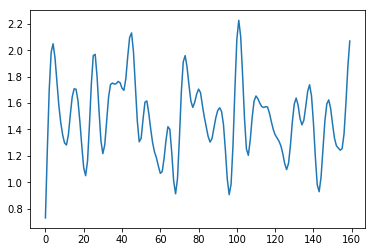

In [13]:
filteredSignalApprox = np.convolve(lpFilter, signal, mode='same')
_ = plt.plot(filteredSignalApprox[0:20*8])

Ahora, deberemos submestrear, para ello debemos "resincronizarnos" con el resultado de la convolución. Del gráfico podemos ver que el primer pulso no está en cero, sino que el pulso está en el índice:

In [14]:
startSample = filteredSignalApprox[:20].argmax()
print("Índice inicial:{0!s}".format(startSample))

Índice inicial:4


Por lo que la señal submuestreada se obtiene comenzando por el índice obtenido

In [15]:
filteredDataApprox = filteredSignalApprox[startSample::len(pulse)]

Finalmente, ahora debemos decidir si cada valor es un bit `1` o bit `0`. Un criterio, por ejemplo, sería elegir un umbral según lo que vemos en el gráfico de aproximadamente $\sim 1.5$.

In [16]:
filteredBitsApprox = np.where(filteredDataApprox > 1.5, 1, 0)

Por último para esta sección, podemos estimar la tasa de bits errados utilizando el header:

In [17]:
BER_LP = (header != filteredBitsApprox[:8*16]).sum()/len(header)
print("Bit Error Rate: {0!s}".format(BER_LP))

Bit Error Rate: 0.3046875


### Filtro adaptado

Para obtener la solución óptima sabemos que el mejor filtro es aquel cuya respuesta impulsiva es idéntica a la de la señal invertida en el tiempo. Por ello, podemos filtrar directamente la señal haciendo:

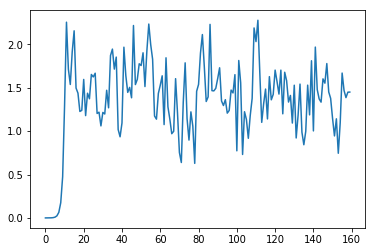

In [18]:
filteredSignal = np.convolve(pulse[::-1], signal, mode='same')
_ = plt.plot(filteredSignal[0:20*8])

Aunque parezca más "ruidosa", el valor de la señal en el lugar donde el filtro está cargado con una copia del pulso, tiene un valor más exacto que el filtro anterior. De hecho, para el ruido insertado, es el más exacto que se puede obtener.

Ahora debemos submuestrear (de nuevo teniendo en cuenta "resincronizarnos"):

In [19]:
filteredData = filteredSignal[int(len(pulse)//2)+1::len(pulse)]

Finalmente debemos decidir por `1` ó `0`. Pero ahora usaremos lo que sabemos de teoría de detección para definir el umbral óptimo.

Sabemos que éste se da en el punto donde las funciones de distribución de probabilidad se cruzan. Dado que en este caso ambos bits son equiprobables y el ruido es el mismo para ambos, podemos estimar este nivel simplemente calculando la media de los valores recibidos ("centro de masa"):

In [20]:
filteredBits = np.where(filteredData > filteredData.mean(), 1, 0)

Finalmente la tasa de bits errados en el header es:

In [21]:
BER_MF = (header != filteredBits[:8*16]).sum()/len(header)
print("Bit Error Rate: {0!s}".format(BER_MF))

Bit Error Rate: 0.0859375


Lo que claramente produce una menor tasa de bits errados.

## Comparación entre señales:

Dado que disponemos de ambas señales, podemos ver por ejemplo en cuanto difieren:

In [22]:
bitsDistintos = (filteredBitsApprox != filteredBits).sum()
print("Bits distintos:",bitsDistintos)

Bits distintos: 481


Y dado que en este caso conocemos la señal original podemos comparar las 3:

In [23]:
print('Bits errados en la señal con filtro LP: {0!s}'.format((bits != filteredBitsApprox).sum()))
print('Bits errados en la señal con filtro MF: {0!s}'.format((bits != filteredBits).sum()))

Bits errados en la señal con filtro LP: 509
Bits errados en la señal con filtro MF: 138


Finalmente resulta evidente la menor tasa de bits errados con los métodos óptimos de detección estudiados.